left_image shape: (512, 512)
right_image shape: (512, 512)


Text(0.5, 1.0, 'RM: Enlarged Cardiomediastinum')

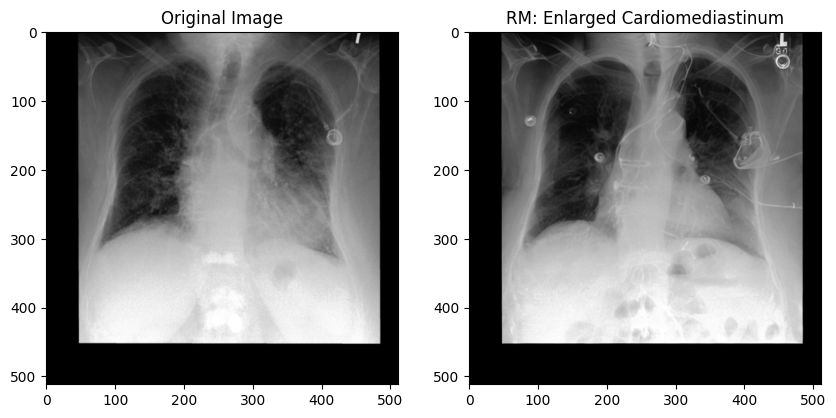

In [42]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import sys
sys.path.append('/media/NAS06/gavinyue/disentanglement')
# from fns_custom.fibmask import * 
# Load the image
left_image = Image.open('/media/NAS06/gavinyue/disentanglement/yingying_tasks/result1_select/89p10439781_s56498272_cbf70dce-197f82f4-7b8613a7-c0b0b099-d1de4726_init.png')
# right_image = Image.open('/media/NAS06/gavinyue/disentanglement/yingying_tasks/result1_select/89p10439781_s56498272_cbf70dce-197f82f4-7b8613a7-c0b0b099-d1de4726_remove_Cardiomegaly_0.png')
right_image = Image.open("/media/NAS06/gavinyue/disentanglement/yingying_tasks/result1_select/89p10439781_s56498272_cbf70dce-197f82f4-7b8613a7-c0b0b099-d1de4726_remove_Enlarged Cardiomediastinum_0_r2gen.png")

left_image = np.array(left_image)
right_image = np.array(right_image)

left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY)
right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY)
print(f'left_image shape: {left_image.shape}')
print(f'right_image shape: {right_image.shape}')

# Show the cropped images (optional)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(left_image,cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(right_image, cmap='gray')
# ax[1].set_title('RM: Cardiomegaly')
ax[1].set_title('RM: Enlarged Cardiomediastinum')

Mask Area: 52807, Min Area: 2640.3500000000004
Component 4 has area 3507
Component 6 has area 4607
Component 13 has area 4879
Component 18 has area 8242
Component 20 has area 4079
Component 21 has area 2874
Intersection Area: 8173, Mask Area: 8242
Intersection Area: 4879, Mask Area: 4879
Intersection Area: 1164, Mask Area: 4607
Intersection Area: 2634, Mask Area: 4079
Intersection Area: 0, Mask Area: 3507


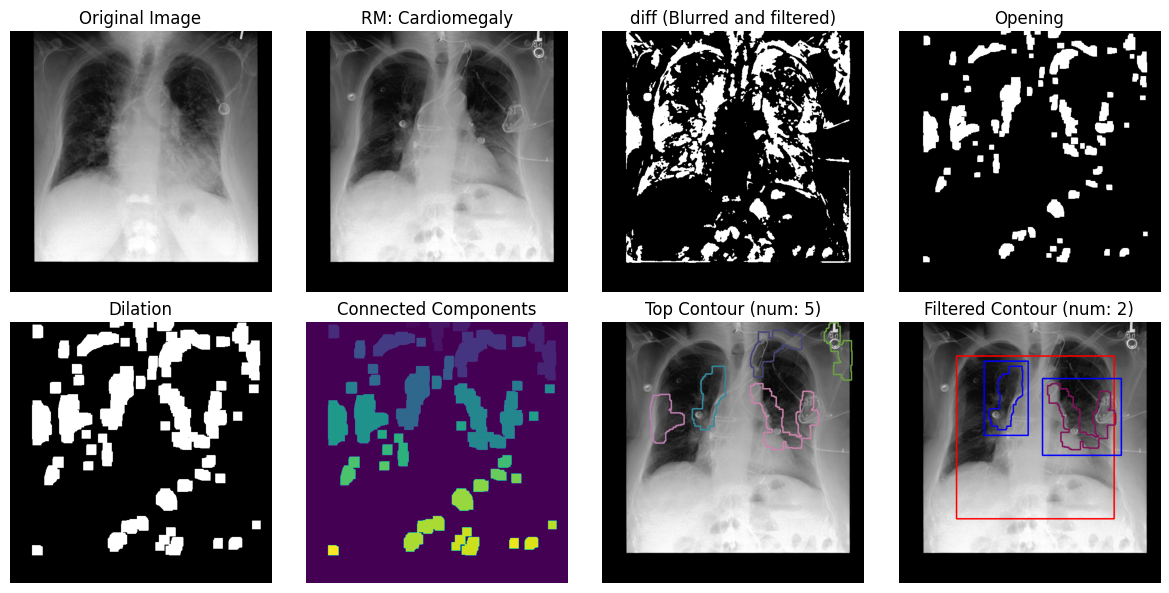

In [44]:
def get_intersection_mask(img1, img2):
    # Convert images to grayscale and apply Gaussian blur
    gray_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) if img1.ndim == 3 else img1
    gray_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY) if img2.ndim == 3 else img2
    gray_img1 = cv2.GaussianBlur(gray_img1, (7, 7), 0)
    gray_img2 = cv2.GaussianBlur(gray_img2, (7, 7), 0)

    # Apply thresholding to get binary images
    # _, thresh_img1 = cv2.threshold(gray_img1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, thresh_img2 = cv2.threshold(gray_img2, 30, 255, cv2.THRESH_BINARY)
    # Create masks from contours
    mask_img1 = np.zeros_like(gray_img1)
    mask_img2 = np.zeros_like(gray_img2)

    # Find contours for the whole image
    contours_img1, _ = cv2.findContours(gray_img1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_img2, _ = cv2.findContours(thresh_img2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cv2.drawContours(mask_img1, contours_img1, -1, color=255, thickness=cv2.FILLED)
    cv2.drawContours(mask_img2, contours_img2, -1, color=255, thickness=cv2.FILLED)

    combined_mask = cv2.bitwise_and(mask_img1, mask_img2)
    return combined_mask

def get_diff_masks(img1, img2):
    assert len(img1.shape) == 2 and len(img2.shape) == 2, "Input images must be grayscale" 
                
    # Compute the absolute difference between the blurred images
    diff = cv2.absdiff(img1, img2)

    # # Remove shape artefactes (hollow and decreased edges)
    combined_mask = get_intersection_mask(img1, img2)
    diff = cv2.bitwise_and(diff, diff, mask=combined_mask)

    # # normalise to [0,255] Useless!
    diff = cv2.normalize(diff, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    # Apply Gaussian Blur to reduce noise
    diff = cv2.GaussianBlur(diff, (5, 5), 0)
    # Apply Otsu's thresholding to get a binary mask
    _, diff_mask = cv2.threshold(diff, 20, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return diff_mask

def get_boxes(img):
    contours = max(cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0], key=cv2.contourArea, default=None)
    if contours is None:
        print(f"Failed to find a box for input image")
        return None

    def draw_box(contour):
        x, y, w, h = cv2.boundingRect(contour)
        mx_start, mx_end = x  + int(w * 0.15), x  + int(w * 0.85)
        my_start, my_end = y + int(h * 0.15), y + int(h * 0.85)
        return (mx_start, my_start, mx_end - mx_start, my_end - my_start)

    middle_box = draw_box(contours)
    return np.array(middle_box)

def get_prompt_box(contour, offset=0):
    x, y, w, h = cv2.boundingRect(contour)
    mx_start, mx_end = x - int(offset/2), x  + int(w) + int(offset/2)
    my_start, my_end = y - int(offset/2), y + int(h) + int(offset/2)
    return np.array([mx_start, my_start, mx_end - mx_start, my_end - my_start])
    


import random
def get_fib_mask(orig_img, manip_img, show=False, middle_boxes=None, debug=False):
    diff_mask = get_diff_masks(orig_img, manip_img)
    # Step 2: Morphological Opening and Dilation
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(diff_mask, cv2.MORPH_OPEN, kernel, iterations=4)
    sure_fg = cv2.dilate(opening, kernel, iterations=4)

    # Step 3: Connected Component Analysis
    num_labels, labels_im = cv2.connectedComponents(sure_fg)

    # Step 4: Filter Components
    # 4.1 Minimum Component is 3% of the mask area
    # 4.2 Sort components by area in descending order and select the top 8
    mask_area = cv2.countNonZero(sure_fg)
    min_area = mask_area * 0.05
    print(f"Mask Area: {mask_area}, Min Area: {min_area}")

    selected_mask = np.zeros_like(sure_fg)
    components = []
    for label in range(1, num_labels):
        component_mask = (labels_im == label).astype(np.uint8) * 255
        area = cv2.countNonZero(component_mask)
        if area >= min_area:
            components.append((area, component_mask))
            print(f"Component {label} has area {area}")
    
    components.sort(key=lambda x: x[0], reverse=True)
    top_components = components[:5]
    output_image = cv2.cvtColor(manip_img.copy(), cv2.COLOR_GRAY2BGR)


    mbox = get_boxes(manip_img)
    # cv2.rectangle(output_image, (mbox[0], mbox[1]), (mbox[0] + mbox[2], mbox[1] + mbox[3]), (0, 0, 255), 2)
    box_mask = np.zeros_like(manip_img, dtype=np.uint8)
    cv2.rectangle(box_mask, (mbox[0], mbox[1]), (mbox[0] + mbox[2], mbox[1] + mbox[3]), 255, thickness=cv2.FILLED)
    cv2.rectangle(output_image, (mbox[0], mbox[1]), (mbox[0] + mbox[2], mbox[1] + mbox[3]), (255, 0, 0), 2)
    
    
    
    output_image1 = cv2.cvtColor(manip_img.copy(), cv2.COLOR_GRAY2BGR)
    for area, mask in top_components: 
    # Calculate the intersection of the selected mask with the box
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
        random_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))# Draw contours with the random color
        cv2.drawContours(output_image1, contours, -1, random_color, 2) 
    
    for area, mask in top_components: 
        # Calculate the intersection of the selected mask with the box
        intersection = cv2.bitwise_and(mask, box_mask)
        intersection_area = cv2.countNonZero(intersection)
        print(f"Intersection Area: {intersection_area}, Mask Area: {cv2.countNonZero(mask)}")
        mask_area = cv2.countNonZero(mask)
        if intersection_area > 0.8 * mask_area:
            selected_mask = cv2.bitwise_or(selected_mask, mask)
    
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
            random_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))# Draw contours with the random color
            for contour in contours:
                box = get_prompt_box(contour,offset=20)
                cv2.rectangle(output_image, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]), (0, 0, 255), 2)
            cv2.drawContours(output_image, contours, -1, random_color, 2)    
        
    # Step 6: Contour Detection on Selected Components
    filter_contours, _ = cv2.findContours(selected_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    segmentation_mask = np.zeros_like(selected_mask, dtype=np.uint8)
    cv2.drawContours(segmentation_mask, filter_contours, -1, 255, thickness=cv2.FILLED)

    # Step 7: fill holes
    segmentation_mask = cv2.morphologyEx(segmentation_mask, cv2.MORPH_CLOSE, kernel, iterations=3)
    
    gt2D = segmentation_mask
    y_indices, x_indices = np.where(gt2D > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = gt2D.shape
    x_min = max(0, x_min - 20)
    x_max = min(W, x_max + 20)
    y_min = max(0, y_min - 20)
    y_max = min(H, y_max + 20)
    bbox = np.array([x_min, y_min, x_max, y_max])
    # cv2.rectangle(output_image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)
    
                
            
    if show:
        fig, axes = plt.subplots(2, 4, figsize=(12, 6)) 
        images = [orig_img, manip_img, diff_mask, opening]
        titles = ["Original Image", "RM: Cardiomegaly", 'diff (Blurred and filtered)','Opening']
        for i, (img, title) in enumerate(zip(images, titles)):
            axes[0, i].imshow(img, cmap='gray')
            axes[0, i].set_title(title)
        
        images2 = [sure_fg, labels_im, output_image1, output_image]
        # titles2 = ['Dilation', 'Connected Components', f'Filtered Contour (num: {len(filter_contours)})', f'Segmentation Mask (num: {len(filter_contours)})']
        titles2 = ['Dilation', 'Connected Components', f'Top Contour (num: {len(top_components)})', f'Filtered Contour (num: {len(filter_contours)})']
        for i, (img, title) in enumerate(zip(images2, titles2)):
            axes[1, i].imshow(img, cmap='gray' if i != 1 else None)
            axes[1, i].set_title(title)

        for ax in axes.flatten():
            ax.axis('off')
        plt.tight_layout()
        # plt.savefig("box_task_Cardiomegaly.png")
        plt.show()
    return output_image, segmentation_mask, len(top_components), len(filter_contours)

img1 = left_image; img2 = right_image
output_image, segmentation_mask, l1, l2 = get_fib_mask(img1, img2, show=True)


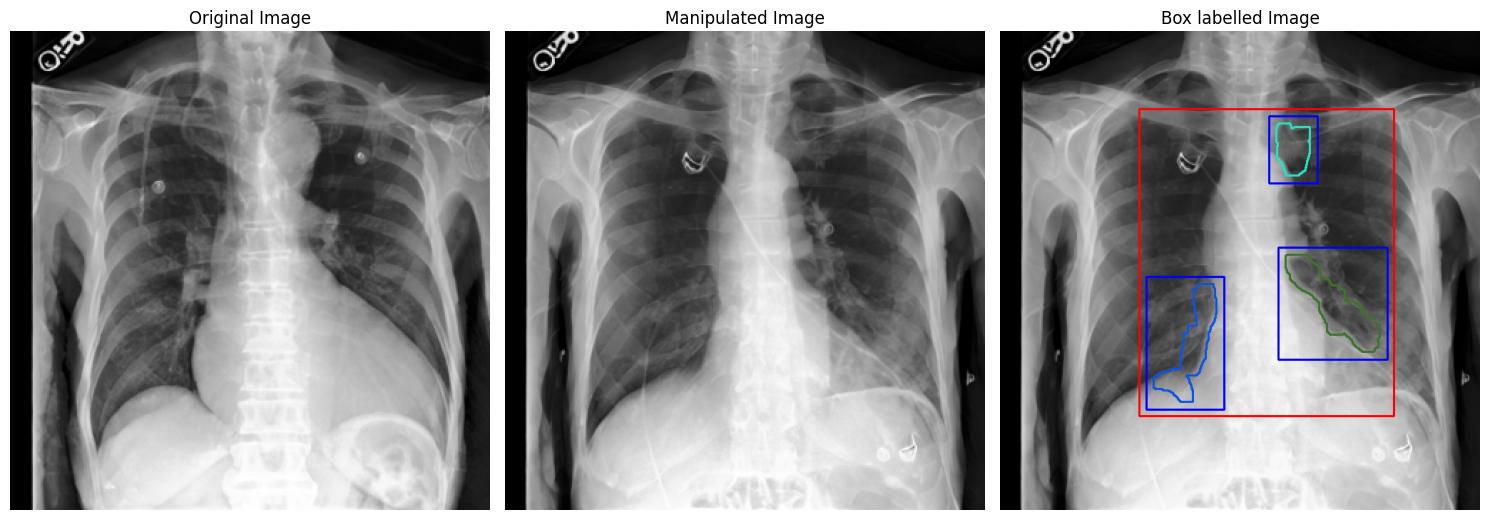

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
axes[0].imshow(img1, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(img2, cmap='gray')
axes[1].set_title('Manipulated Image')
axes[2].imshow(output_image)
axes[2].set_title('Box labelled Image')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.savefig('/media/NAS06/gavinyue/disentanglement/yingying_tasks/box_labelled.png')